In [1]:
import sys
import gc
import collections
from functools import partial

sys.path.append('./nn_modularity_paper/')

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.cluster.hierarchy import cut_tree
import networkx as nx
import sklearn
from sklearn import neighbors
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.cluster.spectral import spectral_embedding
import umap
from scipy.spatial.distance import pdist, squareform
import pygsp

from src.vp_viz import sns_palette_to_rgb_string, make_figure

%config Completer.use_jedi = False

dev = 'cuda:0'

In [104]:
def str_key_dict(vec):
    return dict((str(i),v) for i,v in enumerate(vec))

def save_plotly(fig, path):
    with open(path, "w") as f:
        print(fig.to_html(), file=f)

def create_graph_from_embedding(embedding, name):
    latent_dim, batch_size = embedding.shape
    if name =='gaussian':
        # Compute a gaussian kernel over the node activations
        node_distances = squareform(pdist(embedding, 'sqeuclidean'))
        s = 1
        K = np.exp(-node_distances / s**2)
        K[K < 0.1] = 0
        A = K * (np.ones((latent_dim, latent_dim)) - np.identity(latent_dim))
        return A
    elif name == 'knn':
        #nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=5)
        A = neighbors.kneighbors_graph(embedding, n_neighbors=5).toarray()
        A = (A + np.transpose(A)) / 2 # Symmetrize knn graph
        return A
    elif name == 'adaptive':
        # Find distance of k-th nearest neighbor and set as bandwidth
        neigh = neighbors.NearestNeighbors(n_neighbors=3)
        neigh.fit(embedding)
        dist, _ = neigh.kneighbors(embedding, return_distance=True)
        kdist = dist[:,-1]
        # Apply gaussian kernel with adaptive bandwidth
        node_distances = squareform(pdist(embedding, 'sqeuclidean'))
        K = np.exp(-node_distances / kdist**2)
        A = K * (np.ones((latent_dim, latent_dim)) - np.identity(latent_dim))
        A = (A + np.transpose(A)) / 2 # Symmetrize knn graph
        return A
    else:
        raise RuntimeError('Unknown graph name %s' % name)

In [288]:
class Net(nn.Module):
    def __init__(self, layers, drop_p=0.2):
        super(Net,self).__init__()
        self.hidden = nn.ModuleList()
        for li,lo in zip(layers, layers[1:]):
            self.hidden.append(nn.Linear(li, lo))
        self.droput = nn.Dropout(drop_p)
        
    def forward(self,x):
        x = x.view(-1, INPUT_SHAPE)
        for i,l in enumerate(self.hidden):
            x = l(x)
            if i < len(self.hidden) - 1:
                x = self.droput(F.relu(x))
        return x

def eval_nn(nn, testloader):
    correct = 0
    loss_sublist = []
    for x,y in testloader:
        x,y = x.to(dev), y.to(dev)
        nn.eval()
        z = nn(x)
        _, yh = torch.max(z.data, 1)
        correct += (yh == y).sum().item()
        loss_sublist.append(crit(z, y).data.item())
    acc = correct / n_test
    return acc, round(np.mean(loss_sublist), 4)

def run_nn_train(nn, x, y, optimizer, crit):
    x,y = x.to(dev), y.to(dev)
    nn.train()
    optimizer.zero_grad()
    z = nn(x)
    return crit(z, y)

def clean_mem():
    gc.collect()
    torch.cuda.empty_cache()torch.cuda.empty_cache()

In [368]:
clust_pal = str_key_dict(sns_palette_to_rgb_string(sns.color_palette("Set2", n_colors=4)))
layer_pal = str_key_dict(sns_palette_to_rgb_string(sns.color_palette("Set2", n_colors=3)))

## MNIST

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainset_raw = torchvision.datasets.MNIST(root='./data', train=True, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True, num_workers=12)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False, num_workers=12)

INPUT_SHAPE = 1 * 28 * 28
OUTPUT_SHAPE = 10

## Simple MLP

In [217]:
layers = [INPUT_SHAPE, 25, 15, OUTPUT_SHAPE]
mlp = Net(layers, drop_p=0.3).to(dev)

crit = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

In [218]:
%%time

N_EPOCHS = 20
train_loss_list = []
test_loss_list = []
accuracy_list = []
correct = 0
n_test = len(testset)
graph = None

for e in range(N_EPOCHS):
    activations = collections.defaultdict(list)
    # Train
    loss_sublist = []
    gl_sublist = []
    for x,y in trainloader:
        loss = run_nn_train(graph_mlp, x, y, optimizer=optimizer, crit=crit)
        loss_sublist.append(loss.data.item())

        loss.backward()
        optimizer.step()
        
    train_loss_list.append(np.mean(loss_sublist))

    # Test
    acc, test_loss = eval_nn(graph_mlp, testloader)
    del x,y,loss
    clean_mem()

    test_loss_list.append(test_loss)
    print(f'{e}. Accuracy: {round(acc, 4)}, CE: {test_loss_list[-1]}')

0. Accuracy: 0.7698, CE: 1.0343
1. Accuracy: 0.8503, CE: 0.6417
2. Accuracy: 0.8817, CE: 0.4815
3. Accuracy: 0.8968, CE: 0.4067
4. Accuracy: 0.9063, CE: 0.3575
5. Accuracy: 0.9125, CE: 0.331
6. Accuracy: 0.9156, CE: 0.3079
7. Accuracy: 0.919, CE: 0.2947
8. Accuracy: 0.9228, CE: 0.2805
9. Accuracy: 0.9229, CE: 0.2726
10. Accuracy: 0.9259, CE: 0.2629
11. Accuracy: 0.9289, CE: 0.2593
12. Accuracy: 0.9305, CE: 0.2509
13. Accuracy: 0.9315, CE: 0.2461
14. Accuracy: 0.9321, CE: 0.2438
15. Accuracy: 0.9306, CE: 0.2468
16. Accuracy: 0.934, CE: 0.2364
17. Accuracy: 0.9343, CE: 0.2365
18. Accuracy: 0.9375, CE: 0.231
19. Accuracy: 0.9348, CE: 0.2327
CPU times: user 14.9 s, sys: 19.6 s, total: 34.5 s
Wall time: 1min 33s


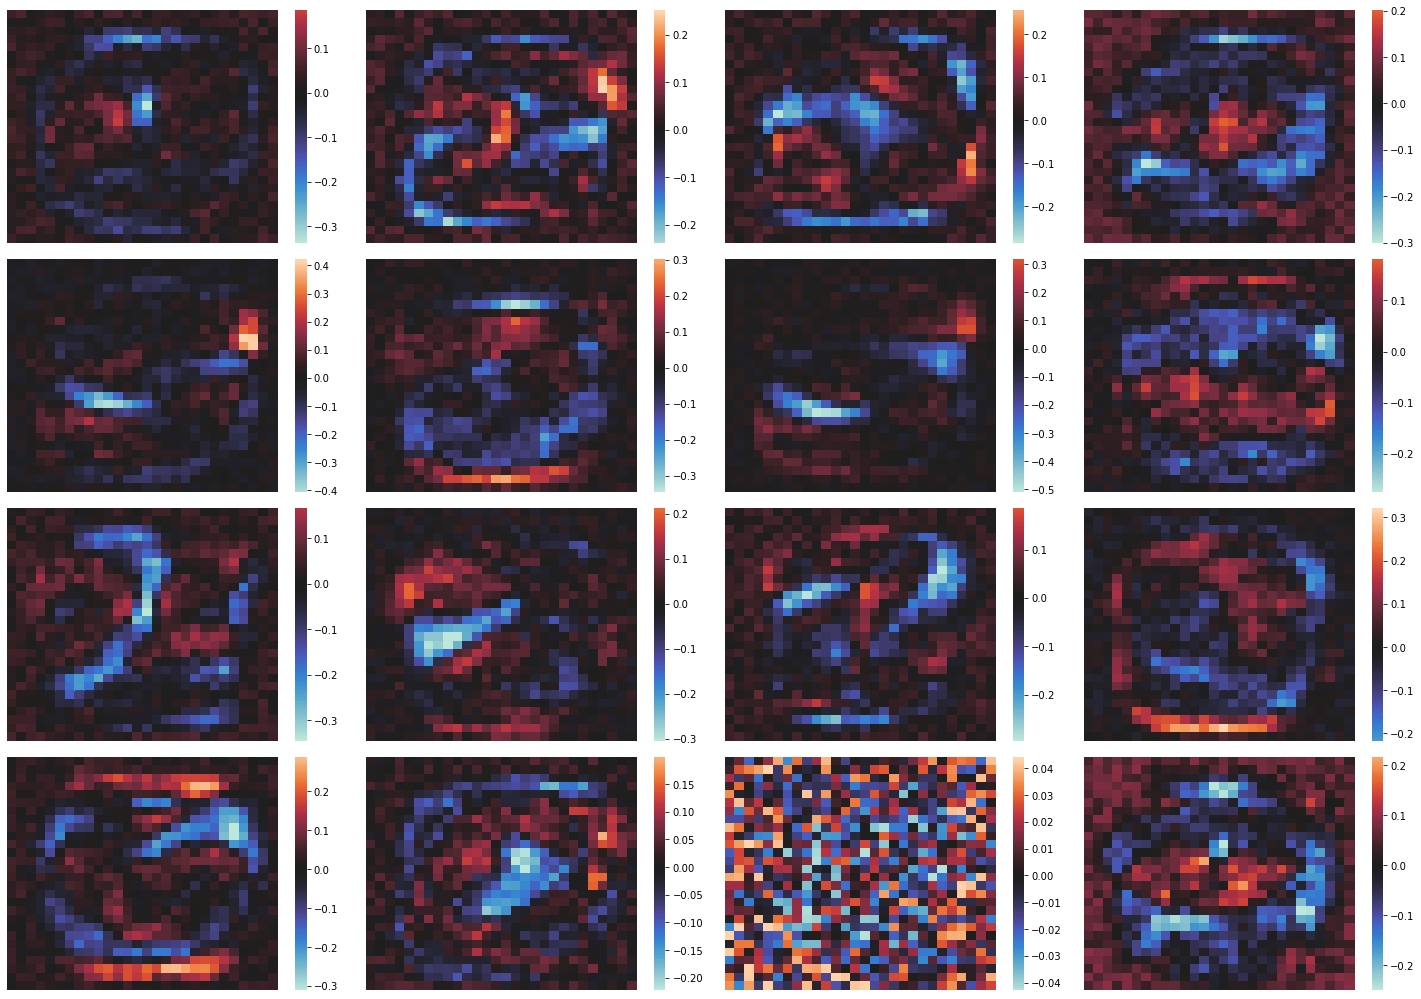

In [228]:
l1 = dict(mlp.named_modules())['hidden.0']
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 14))
for i in range(16):
    sns.heatmap(list(l1.parameters())[0][i,:].reshape(28, 28).cpu().detach().numpy(), xticklabels=False, yticklabels=False, center=0, ax=axes.flatten()[i])

plt.tight_layout()

### Visualization

In [361]:
activations = collections.defaultdict(list)
def save_activation(name, mod, inp, out):
    activations[name].append(out.cpu())

for name, m in mlp.named_modules():
    if type(m)==nn.Linear:
        m.register_forward_hook(partial(save_activation, name))

In [364]:
activations = collections.defaultdict(list)
for x,y in trainloader:
    mlp.eval()
    z = mlp(x.to(dev))

In [365]:
joint_activations = torch.hstack([torch.vstack(activations[f'hidden.{fi}']) for fi in range(3)]).detach().numpy()
adj_mat = create_graph_from_embedding(joint_activations.T, 'adaptive')
graph = nx.Graph(adj_mat)

In [366]:
n_clusts = 4
cluster_alg = SpectralClustering(n_clusters=n_clusts, eigen_solver='amg', affinity='precomputed', assign_labels='kmeans')
clusts = cluster_alg.fit(adj_mat).labels_

spec_emb = spectral_embedding(adj_mat, n_components=n_clusts, eigen_solver='amg')
# %time emb = umap.UMAP(n_neighbors=50, spread=2, min_dist=1).fit_transform(spec_emb)

In [369]:
layer_labs = np.concatenate([[i] * activations[f'hidden.{i}'][0].shape[1] for i in range(3)])

In [370]:
palettes = dict(Layer=layer_pal, Cluster=clust_pal)
color_groups = dict(Layer=layer_labs.astype(str), Cluster=clusts.astype(str))

fig = make_figure(spec_emb[:,:3], metadata={}, clusters=color_groups, palette=palettes, ms=3)
save_plotly(fig, "./output/coactivation/fig_mlp.html")

## Graph MLP

In [283]:
layers = [INPUT_SHAPE, 25, 15, OUTPUT_SHAPE]
graph_mlp = Net(layers, drop_p=0.3).to(dev)

crit = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(graph_mlp.parameters(), lr=0.001)

In [284]:
activations = collections.defaultdict(list)
def save_activation(name, mod, inp, out):
    activations[name].append(out.cpu())

for name, m in graph_mlp.named_modules():
    if type(m)==nn.Linear:
        m.register_forward_hook(partial(save_activation, name))

In [285]:
%%time

N_EPOCHS = 40
train_loss_list = []
test_loss_list = []
accuracy_list = []
correct = 0
n_test = len(testset)
graphs = [None, None]
n_hidden = 2

for e in range(N_EPOCHS):
    activations = collections.defaultdict(list)
    # Train
    loss_sublist = []
    gl_sublist = []
    for x,y in trainloader:
        loss = run_nn_train(graph_mlp, x, y, optimizer=optimizer, crit=crit)
        loss_sublist.append(loss.data.item())
        
        if graphs[0] is not None:
            for li in range(n_hidden):
                graph_losses = []
                act = activations[f'hidden.{li}'][-1]
                lap = torch.Tensor(graphs[li].L.A)
                for i in range(len(act)):
                    v = act[i:(i+1),:]
                    graph_losses.append(v.mm(lap).mm(v.T))

                loss += torch.vstack(graph_losses).mean() * 0.01 / n_hidden
            gl_sublist.append(loss.data.item() - loss_sublist[-1])
        
        loss.backward()
        optimizer.step()
        
    train_loss_list.append(np.mean(loss_sublist))
    
    # Loss update
    for li in range(n_hidden):
        adj_mat = create_graph_from_embedding(torch.vstack(activations[f'hidden.{li}']).detach().numpy().T, 'adaptive')
        graph = pygsp.graphs.Graph(adj_mat)
        graph.compute_laplacian(lap_type='normalized')
        graphs[li] = graph

    # Test
    acc, test_loss = eval_nn(graph_mlp, testloader)
    del x,y,loss
    clean_mem()

    graph_loss = 0
    if len(gl_sublist) > 0:
        graph_loss = np.mean(gl_sublist)
    print(f'{e}. Accuracy: {round(acc, 4)}, CE: {test_loss_list[-1]}, GL: {round(graph_loss, 3)}')

0. Accuracy: 0.759, CE: 0.973, GL: 0
1. Accuracy: 0.8462, CE: 0.9455, GL: 0.374
2. Accuracy: 0.8696, CE: 0.7512, GL: 0.205
3. Accuracy: 0.8817, CE: 0.6364, GL: 0.19
4. Accuracy: 0.8863, CE: 0.5623, GL: 0.181
5. Accuracy: 0.896, CE: 0.5203, GL: 0.172
6. Accuracy: 0.8983, CE: 0.478, GL: 0.167
7. Accuracy: 0.9044, CE: 0.4336, GL: 0.161
8. Accuracy: 0.9095, CE: 0.4158, GL: 0.157
9. Accuracy: 0.9105, CE: 0.3948, GL: 0.153
10. Accuracy: 0.9118, CE: 0.3723, GL: 0.147
11. Accuracy: 0.9159, CE: 0.3659, GL: 0.144
12. Accuracy: 0.9165, CE: 0.3612, GL: 0.141
13. Accuracy: 0.9186, CE: 0.3335, GL: 0.137
14. Accuracy: 0.922, CE: 0.3335, GL: 0.135
15. Accuracy: 0.9174, CE: 0.3229, GL: 0.13
16. Accuracy: 0.9201, CE: 0.3258, GL: 0.13
17. Accuracy: 0.9199, CE: 0.3102, GL: 0.127
18. Accuracy: 0.9214, CE: 0.3226, GL: 0.125
19. Accuracy: 0.9241, CE: 0.3123, GL: 0.124
20. Accuracy: 0.9225, CE: 0.3002, GL: 0.122
21. Accuracy: 0.9239, CE: 0.2949, GL: 0.12
22. Accuracy: 0.9227, CE: 0.2925, GL: 0.119
23. Accurac

/home/vpetukhov/local/miniconda3/envs/nns/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


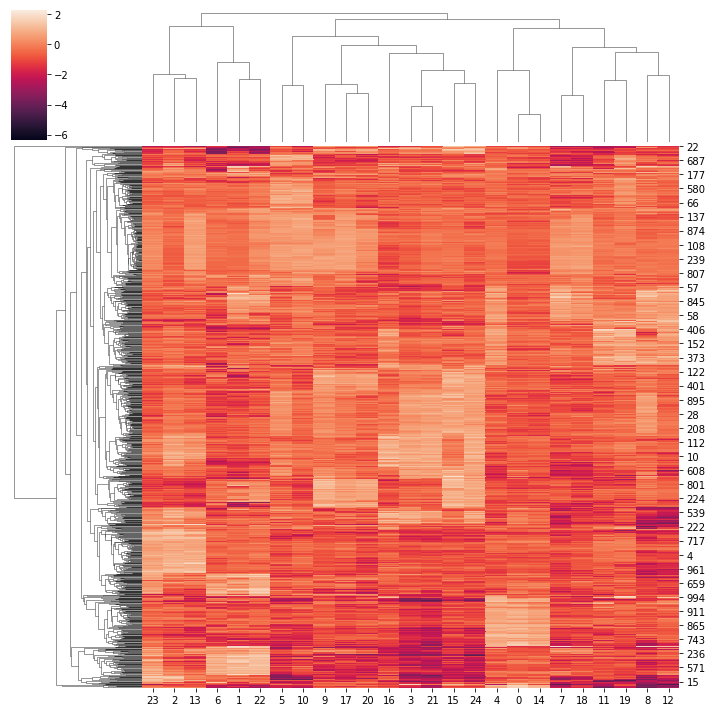

In [289]:
import seaborn as sns
sns.clustermap(torch.vstack(activations['hidden.0']).detach().numpy()[:1000,:])

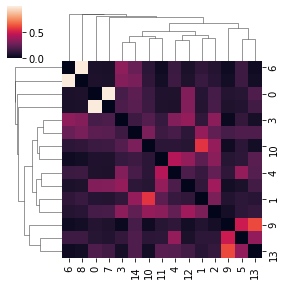

In [304]:
sns.clustermap(graphs[1].W.A, method='ward', figsize=(4, 4))

/home/vpetukhov/local/miniconda3/envs/nns/lib/python3.8/site-packages/seaborn/matrix.py:619: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


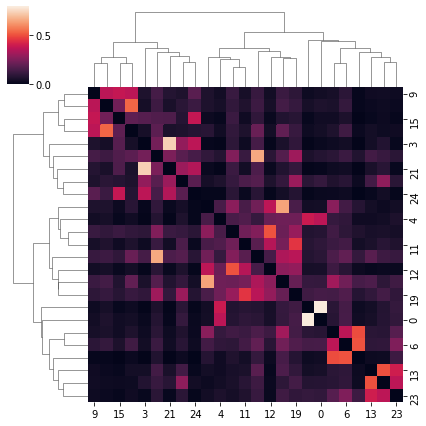

In [301]:
res = sns.clustermap(graphs[0].W.A, method='ward', figsize=(6, 6))
clust_labels = cut_tree(res.dendrogram_col.linkage, n_clusters=3).flatten()

In [260]:
pd.value_counts(clust_labels)

0    14
1     7
2     4
dtype: int64

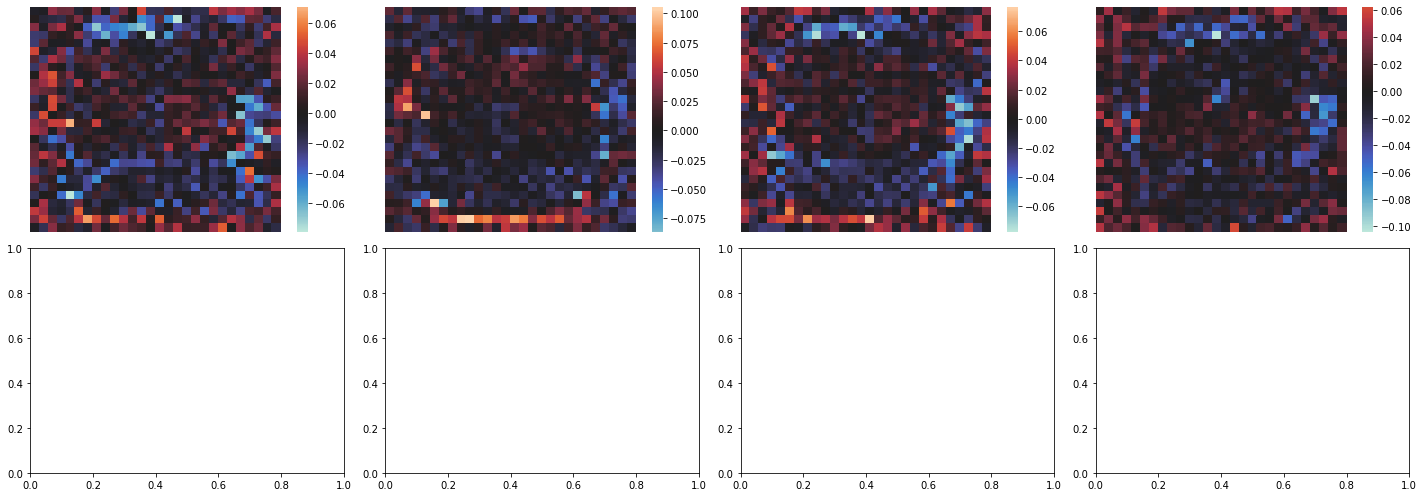

In [263]:
l1 = dict(graph_mlp.named_modules())['hidden.0']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 7))
for ai,i in enumerate(np.where(clust_labels == 2)[0]):
    sns.heatmap(list(l1.parameters())[0][i,:].reshape(28, 28).cpu().detach().numpy(), xticklabels=False, yticklabels=False, center=0, ax=axes.flatten()[ai])

plt.tight_layout()

### Visualization

In [374]:
activations = collections.defaultdict(list)
for x,y in trainloader:
    graph_mlp.eval()
    z = graph_mlp(x.to(dev))

layer_labs = np.concatenate([[i] * activations[f'hidden.{i}'][0].shape[1] for i in range(3)])

In [375]:
joint_activations = torch.hstack([torch.vstack(activations[f'hidden.{fi}']) for fi in range(3)]).detach().numpy()
adj_mat = create_graph_from_embedding(joint_activations.T, 'knn')
graph = nx.Graph(adj_mat)

In [376]:
n_clusts = 4
cluster_alg = SpectralClustering(n_clusters=n_clusts, eigen_solver='amg', affinity='precomputed', assign_labels='kmeans')
clusts = cluster_alg.fit(adj_mat).labels_

spec_emb = spectral_embedding(adj_mat, n_components=n_clusts, eigen_solver='amg')
# %time emb = umap.UMAP(n_neighbors=50, spread=2, min_dist=1).fit_transform(spec_emb)

In [377]:
palettes = dict(Layer=layer_pal, Cluster=clust_pal)
color_groups = dict(Layer=layer_labs.astype(str), Cluster=clusts.astype(str))

fig = make_figure(spec_emb[:,:3], metadata={}, clusters=color_groups, palette=palettes, ms=3)
save_plotly(fig, "./output/coactivation/fig_graph_knn.html")

## Joing Graph MLP

In [491]:
layers = [INPUT_SHAPE, 25, 15, OUTPUT_SHAPE]
mlp_graph_joint = Net(layers, drop_p=0.3).to(dev)

crit = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_graph_joint.parameters(), lr=0.001)
layer_labs = np.concatenate([[i] * l for i,l in enumerate(layers[1:])])

In [492]:
activations = collections.defaultdict(list)
def save_activation(name, mod, inp, out):
    activations[name].append(out.cpu())

for name, m in mlp_graph_joint.named_modules():
    if type(m)==nn.Linear:
        m.register_forward_hook(partial(save_activation, name))

In [493]:
%%time

N_EPOCHS = 40
train_loss_list = []
test_loss_list = []
accuracy_list = []
correct = 0
n_test = len(testset)
graph = None
n_hidden = 2

for e in range(N_EPOCHS):
    activations = collections.defaultdict(list)
    # Train
    loss_sublist = []
    gl_sublist = []
    for x,y in trainloader:
        loss = run_nn_train(mlp_graph_joint, x, y, optimizer=optimizer, crit=crit)
        loss_sublist.append(loss.data.item())
        
        if graph is not None:
            graph_losses = []
            joint_activations = torch.hstack([activations[f'hidden.{fi}'][-1] for fi in range(3)])
            lap = torch.Tensor(graph.L.A)
            for i in range(joint_activations.shape[0]):
                v = joint_activations[i:(i+1),:]
                graph_losses.append(v.mm(lap).mm(v.T))

            gl = torch.vstack(graph_losses).mean() * 0.15
            loss += gl
            gl_sublist.append(gl.data.item())
        
        loss.backward()
        optimizer.step()
        
    train_loss_list.append(np.mean(loss_sublist))
    
    # Loss update
    joint_activations = torch.hstack([torch.vstack(activations[f'hidden.{fi}']) for fi in range(3)]).detach().numpy()
    adj_mat = create_graph_from_embedding(joint_activations.T, 'adaptive')
    adj_mat[np.ix_(layer_labs == 0, layer_labs == 2)] = 0
    adj_mat[np.ix_(layer_labs == 2, layer_labs == 0)] = 0
    adj_mat[np.ix_(layer_labs == 2, layer_labs == 2)] = 0
    graph = pygsp.graphs.Graph(adj_mat)
    graph.compute_laplacian(lap_type='normalized')

    # Test
    acc, test_loss = eval_nn(mlp_graph_joint, testloader)
    del x,y,loss
    clean_mem()

    graph_loss = 0
    if len(gl_sublist) > 0:
        graph_loss = np.mean(gl_sublist)
    
    test_loss_list.append(test_loss)
    print(f'{e}. Accuracy: {round(acc, 4)}, CE: {test_loss_list[-1]}, GL: {round(graph_loss, 3)}')

0. Accuracy: 0.8229, CE: 0.8297, GL: 0
1. Accuracy: 0.2281, CE: 2.2593, GL: 5.543
2. Accuracy: 0.4107, CE: 2.2207, GL: 0.248
3. Accuracy: 0.578, CE: 2.1905, GL: 0.154
4. Accuracy: 0.6427, CE: 2.1531, GL: 0.13
5. Accuracy: 0.6521, CE: 2.1185, GL: 0.125
6. Accuracy: 0.6577, CE: 2.0819, GL: 0.127
7. Accuracy: 0.6547, CE: 2.0519, GL: 0.132
8. Accuracy: 0.6491, CE: 2.0229, GL: 0.138
9. Accuracy: 0.651, CE: 1.9965, GL: 0.144
10. Accuracy: 0.6679, CE: 1.9829, GL: 0.149
11. Accuracy: 0.6666, CE: 1.96, GL: 0.154
12. Accuracy: 0.687, CE: 1.9495, GL: 0.159
13. Accuracy: 0.7159, CE: 1.9309, GL: 0.163
14. Accuracy: 0.6961, CE: 1.8985, GL: 0.17
15. Accuracy: 0.7312, CE: 1.8859, GL: 0.177
16. Accuracy: 0.7407, CE: 1.8789, GL: 0.185
17. Accuracy: 0.7299, CE: 1.8525, GL: 0.189
18. Accuracy: 0.7373, CE: 1.8554, GL: 0.196
19. Accuracy: 0.7485, CE: 1.844, GL: 0.203
20. Accuracy: 0.7281, CE: 1.8019, GL: 0.209
21. Accuracy: 0.7451, CE: 1.7948, GL: 0.214
22. Accuracy: 0.7234, CE: 1.7887, GL: 0.219
23. Accura

/home/vpetukhov/local/miniconda3/envs/nns/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



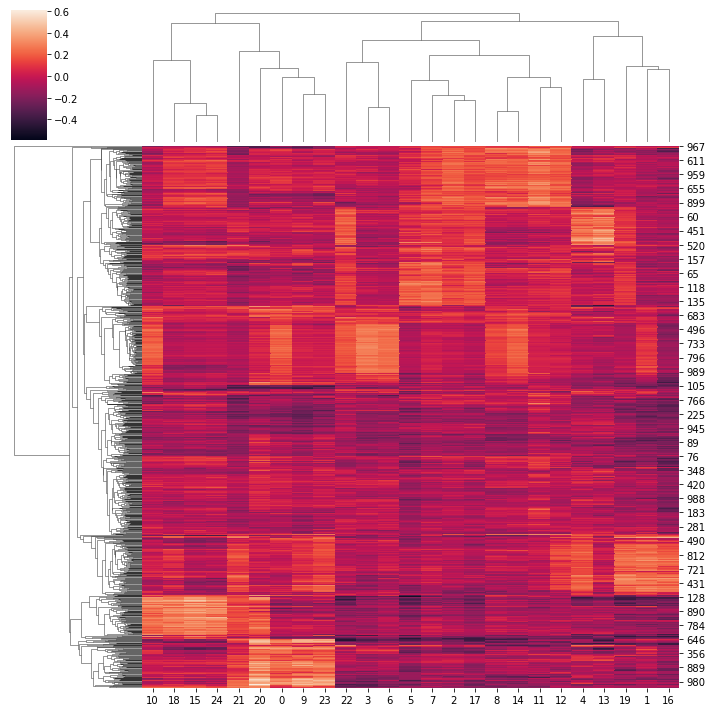

In [494]:
import seaborn as sns
sns.clustermap(torch.vstack(activations['hidden.0']).detach().numpy()[:1000,:])

/home/vpetukhov/local/miniconda3/envs/nns/lib/python3.8/site-packages/seaborn/matrix.py:619: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



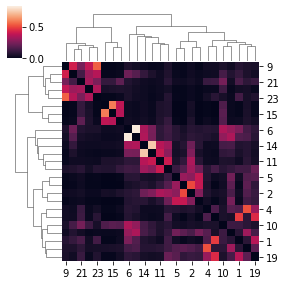

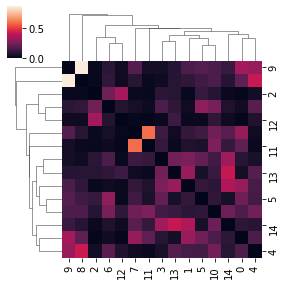

In [495]:
sns.clustermap(graph.W.A[layer_labs == 0, :][:, layer_labs == 0], method='ward', figsize=(4, 4))
sns.clustermap(graph.W.A[layer_labs == 1, :][:, layer_labs == 1], method='ward', figsize=(4, 4))

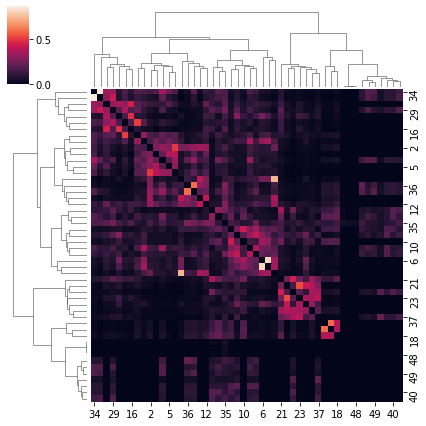

In [496]:
res = sns.clustermap(graph.W.A, method='ward', figsize=(6, 6))
clust_labels = cut_tree(res.dendrogram_col.linkage, n_clusters=4).flatten()

In [497]:
pd.value_counts(clust_labels)

2    23
3    13
0     7
1     7
dtype: int64

In [474]:
# l1 = dict(graph_mlp.named_modules())['hidden.0']
# fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 7))
# for ai,i in enumerate(np.where(clust_labels == 3)[0]):
#     if ai >= 8:
#         break
#     sns.heatmap(list(l1.parameters())[0][i,:].reshape(28, 28).cpu().detach().numpy(), xticklabels=False, yticklabels=False, center=0, ax=axes.flatten()[ai])

# plt.tight_layout()

### Visualization

In [498]:
activations = collections.defaultdict(list)
for x,y in trainloader:
    mlp_graph_joint.eval()
    z = mlp_graph_joint(x.to(dev))

layer_labs = np.concatenate([[i] * activations[f'hidden.{i}'][0].shape[1] for i in range(3)])
neuron_labs = np.concatenate([list(range(activations[f'hidden.{i}'][0].shape[1])) for i in range(3)])

In [511]:
correct = [0 for _ in range(10)]
true_total = [0 for _ in range(10)]
predicted_total = [0 for _ in range(10)]

loss_sublist = []
for x,y in testloader:
    x,y = x.to(dev), y.to(dev)
    mlp_graph_joint.eval()
    z = mlp_graph_joint(x)
    _, yh = torch.max(z.data, 1)
    for cl in range(10):
        mtrue = (y == cl)
        mpred = (yh == cl)
        correct[cl] += (yh[mtrue] == y[mtrue]).sum().item()
        true_total[cl] += mtrue.sum().item()
        predicted_total[cl] += mpred.sum().item()

In [513]:
pd.Series(np.array(correct) / np.array(true_total))

0    0.980612
1    0.974449
2    0.896318
3    0.893069
4    0.930754
5    0.000000
6    0.902923
7    0.901751
8    0.001027
9    0.861249
dtype: float64

In [517]:
tl = list(dict(graph_mlp.named_modules())['hidden.2'].parameters())

In [ ]:
sns.clustermap(graph.W.A, method='ward', figsize=(6, 6))

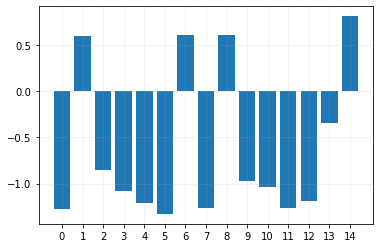

In [539]:
x_vals = np.arange(15)
plt.bar(x_vals, tl[0][0,:].cpu().detach().numpy());
plt.xticks(x_vals);
plt.grid(alpha=0.2)

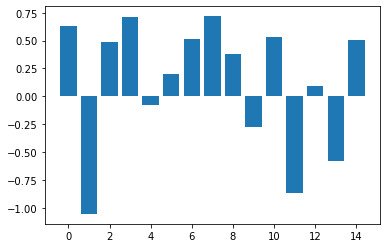

In [530]:
plt.bar(np.arange(15), tl[0][3,:].cpu().detach().numpy());

In [499]:
joint_activations = torch.hstack([torch.vstack(activations[f'hidden.{fi}']) for fi in range(3)]).detach().numpy()
adj_mat = create_graph_from_embedding(joint_activations.T, 'adaptive')
graph = nx.Graph(adj_mat)

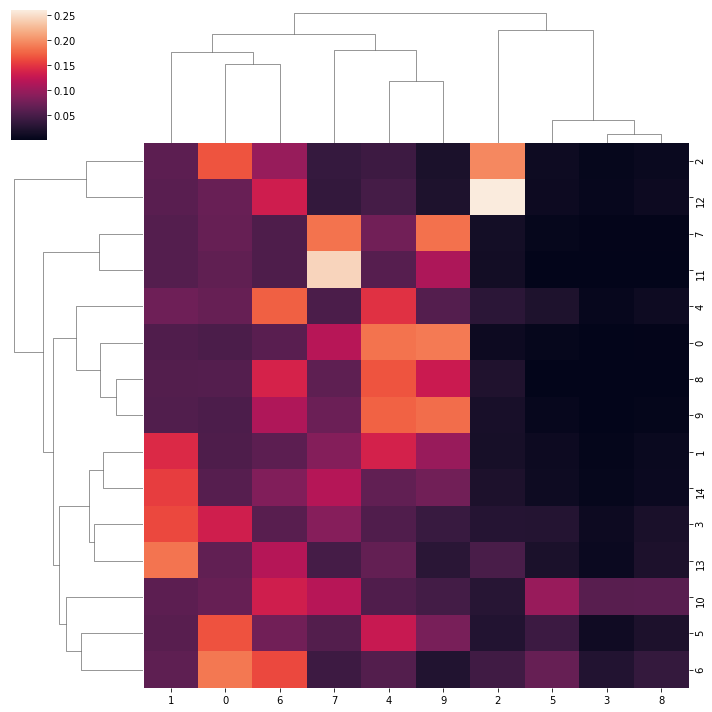

In [552]:
sns.clustermap(adj_mat[np.ix_(layer_labs == 1, layer_labs == 2)]);

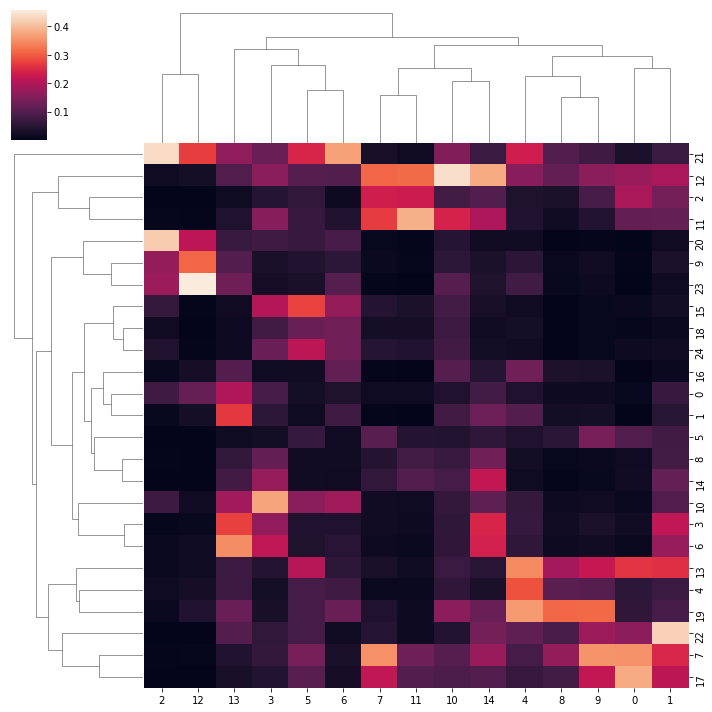

In [553]:
sns.clustermap(adj_mat[np.ix_(layer_labs == 0, layer_labs == 1)]);

In [561]:
trainset_raw[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7FE8F6A4B790>, 5)

In [569]:
for i in range(50):
    x,y = trainset_raw[i]
    if y == 2:
        display(x)

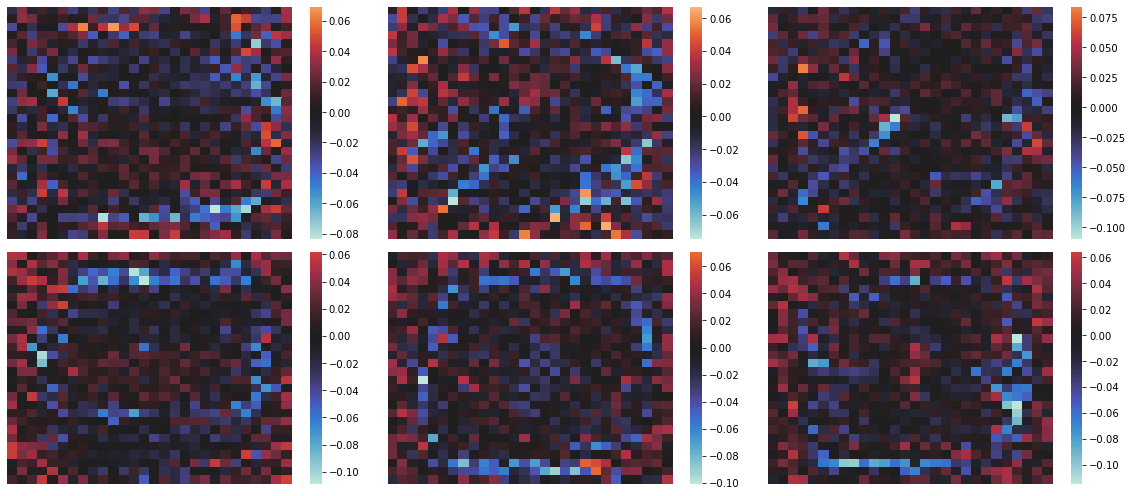

In [555]:
l1 = dict(graph_mlp.named_modules())['hidden.0']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 7))
for ai,i in enumerate([23, 9, 20, 21, 0, 10]):
    sns.heatmap(list(l1.parameters())[0][i,:].reshape(28, 28).cpu().detach().numpy(), xticklabels=False, yticklabels=False, center=0, ax=axes.flatten()[ai])

plt.tight_layout()

In [ ]:
l1 = dict(graph_mlp.named_modules())['hidden.0']
sns.heatmap(list(l1.parameters())[0][i,:].reshape(28, 28).cpu().detach().numpy(), xticklabels=False, yticklabels=False, center=0)

In [500]:
n_clusts = 4
cluster_alg = SpectralClustering(n_clusters=n_clusts, eigen_solver='amg', affinity='precomputed', assign_labels='kmeans')
clusts = cluster_alg.fit(adj_mat).labels_

spec_emb = spectral_embedding(adj_mat, n_components=n_clusts, eigen_solver='amg')
# %time emb = umap.UMAP(n_neighbors=50, spread=2, min_dist=1).fit_transform(spec_emb)

In [506]:
palettes = dict(Layer=layer_pal, Cluster=clust_pal)
color_groups = dict(Layer=layer_labs.astype(str), Cluster=clusts.astype(str))

fig = make_figure(spec_emb[:,:3], metadata={'ID': neuron_labs.astype(str)}, clusters=color_groups, palette=palettes, ms=3)
save_plotly(fig, "./output/coactivation/fig_graph_joint2.html")